# Enhance your brand using YouTube


## 📖 Background
You're a data scientist at a global marketing agency that helps some of the world's largest companies enhance their online presence.

Your new project is exciting: identify the most effective YouTube videos to promote your clients’ brands.

Forget simple metrics like views or likes; your job is to dive deep and discover who really connects with audiences through innovative content analysis.

## 💾 The Data

The data for this competition is stored in two tables, `videos_stats` and `comments`.

### `videos_stats.csv`
This table contains aggregated data for each YouTube video:
- **Video ID**: A unique identifier for each video.
- **Title**: The title of the video.
- **Published At**: The publication date of the video.
- **Keyword**: The main keyword or topic of the video.
- **Likes**: The number of likes the video has received.
- **Comments**: The number of comments on the video.
- **Views**: The total number of times the video has been viewed.

### `comments.csv`
This table captures details about comments made on YouTube videos:
- **Video ID**: The identifier for the video the comment was made on (matches the `Videos Stats` table).
- **Comment**: The text of the comment.
- **Likes**: How many likes this comment has received.
- **Sentiment**: The sentiment score ranges from 0 (negative) to 2 (positive), indicating the tone of a comment.

# Executive Summary

This report explores how data science techniques can be used to identify the most effective YouTube videos for promoting a client's brand. It analyzes two datasets, "videos_stats.csv" containing video metadata and "comments.csv" containing comments on those videos.

Data Cleaning and Exploration
- Both datasets were cleaned to handle missing values, outliers, and data types.
- Exploratory data analysis revealed insights into video statistics, engagement metrics, and keyword classifications.

Engagement Metrics
- A new metric, "Engagement Rate," was calculated by combining likes, comments, and views.
- The average engagement rate was compared by keyword and industry to identify high-performing areas.

Keyword-Based Analysis
- Keywords were categorized into industries to understand industry-specific trends.
- Word clouds were used to visualize the most frequent keywords within each industry.

Sentiment Analysis
- Sentiment analysis was performed on comments to categorize them as positive, neutral, or negative.
- Overall sentiment was positive, with further exploration revealing industry-specific sentiment variations.
- Emotion analysis was conducted to identify the prevalence of various emotions in the comments.
- Average emotion scores were calculated by keyword and industry, revealing interesting trends.
- Time-series analysis showed the evolution of average emotion scores over time, uncovering potential peaks and trends.

Key Findings
- Engagement rate varies by keyword and industry.
- Positive comments are most common overall, but sentiment varies by industry.
- Trust is the dominant emotion, followed by anticipation and joy.
- Specific emotions show peaks and trends over time, offering insights into audience reactions.

# Preparing Data

## Install Libraries

In [209]:
!pip3 install nrclex
!pip3 install seaborn
!pip3 WordCloud
!pip3 install wordcloud
!pip3 install langdetect
!pip3 install numpy pandas matplotlib seaborn pillow wordcloud tqdm scikit-learn nltk nrclex spacy plotly
!pip3 install nbformat --upgrade


!python3 -m spacy download en_core_web_sm

ERROR: unknown command "WordCloud"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Importing Libraries

In [208]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nrclex import NRCLex
import nltk
import os
import re
import string
import random
import warnings
import numpy as np

# Other imports (without duplicates)
import collections  # for Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# NLTK download (combined)
nltk.download('punkt')

# Plotly imports
import plotly.express as px
import plotly.figure_factory as ff
from plotly import graph_objs as go
import nbformat

# Matplotlib and warnings setup
%matplotlib inline
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing Data

In [157]:
print("Youtube Data before cleaning:")
videos_stats = pd.read_csv('/Users/mac/Documents/GitHub/youtube-brand/videos_stats.csv')
videos_stats.head()

Youtube Data before cleaning:


,Title,Video ID,Published At,Keyword,Likes,Comments,Views
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,23/08/2022,tech,3407.0,672.0,135612.0
1,The most EXPENSIVE thing I own.,b3x28s61q3c,24/08/2022,tech,76779.0,4306.0,1758063.0
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,23/08/2022,tech,63825.0,3338.0,1564007.0
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,23/08/2022,tech,71566.0,1426.0,922918.0
4,Best Back to School Tech 2022!,ErMwWXQxHp0,08/08/2022,tech,96513.0,5155.0,1855644.0


In [158]:
print("Comment Data before cleaning:")
comments = pd.read_csv('/Users/mac/Documents/GitHub/youtube-brand/comments.csv')
comments.head()

Comment Data before cleaning:


,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2


## Cleaning Data

### Cleaning Video Data

In [159]:
# Create a copy of the DataFrame to work on
vs_clean = videos_stats.copy()

# 1. Handling missing values
for column in videos_stats.columns:
    if vs_clean[column].dtype == 'object':
        vs_clean[column].fillna(vs_clean[column].mode()[0], inplace=True)
    else:
        vs_clean[column].fillna(vs_clean[column].median(), inplace=True)

# 2. Convert data types 'Published At' to datetime
vs_clean['Published At'] = pd.to_datetime(vs_clean['Published At'], errors='coerce')

# 3. Remove duplicates
vs_clean.drop_duplicates(inplace=True)

# 4. Normalize data (Example: Handling outliers in 'Likes')
q_low = vs_clean['Likes'].quantile(0.01)
q_hi  = vs_clean['Likes'].quantile(0.99)
vs_clean= vs_clean[(vs_clean['Likes'] > q_low) & (vs_clean['Likes'] < q_hi)]

# Display the cleaned data & Save the cleaned data back to a new CSV file
print("Youtube Data after cleaning:")
vs_clean.to_csv('videos_stats_cleaned.csv', index=False)
vs_df_clean = pd.read_csv('videos_stats_cleaned.csv')
vs_df_clean

Youtube Data after cleaning:


,Title,Video ID,Published At,Keyword,Likes,Comments,Views
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,2022-08-23,tech,3407.0,672.0,135612.0
1,The most EXPENSIVE thing I own.,b3x28s61q3c,2022-08-24,tech,76779.0,4306.0,1758063.0
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,2022-08-23,tech,63825.0,3338.0,1564007.0
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,2022-08-23,tech,71566.0,1426.0,922918.0
4,Best Back to School Tech 2022!,ErMwWXQxHp0,2022-08-08,tech,96513.0,5155.0,1855644.0
...,...,...,...,...,...,...,...
1838,Should You Learn Machine Learning?,AO6urf07KjE,2021-06-14,machine learning,10259.0,416.0,386360.0
1839,Todos podemos aprender Machine learning,7ClLKBUvmRk,2017-10-08,machine learning,2981.0,72.0,431421.0
1840,"Andrew Ng: Deep Learning, Education, and Real-...",0jspaMLxBig,2020-02-20,machine learning,5198.0,443.0,226152.0
1841,What is Machine Learning?,f_uwKZIAeM0,2017-01-11,machine learning,14787.0,814.0,591721.0


### Cleaning Comments Data

In [160]:
# Create a copy of the DataFrame to work on
cm_clean = comments.copy()

# 1. Handling missing values
cm_clean.dropna(subset=['Comment'], inplace=True)  # Drop rows where 'Comment' is missing
cm_clean['Likes'] = cm_clean['Likes'].fillna(0)  # Fill missing 'Likes' with 0
cm_clean['Sentiment'] = cm_clean['Sentiment'].fillna(cm_clean['Sentiment'].median())

# 2. Convert data types
cm_clean['Likes'] = cm_clean['Likes'].astype(int)
cm_clean['Sentiment'] = cm_clean['Sentiment'].astype(int)

# 3. Data normalization
cm_clean['Comment'] = cm_clean['Comment'].str.strip()  # Remove extra spaces and newlines

# 4. Validate 'Sentiment' values
cm_clean = cm_clean[(cm_clean['Sentiment'] >= 0) & (cm_clean['Sentiment'] <= 2)]

# Save the cleaned data back to a new CSV file
cm_clean.to_csv('comments_cleaned.csv', index=False)

cm_df_clean = pd.read_csv('/Users/mac/Documents/GitHub/youtube-brand/comments_cleaned.csv',
                 lineterminator='\n')

cm_df_clean


,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2
...,...,...,...,...
18403,cyLWtMSry58,I really like the point about engineering tool...,0,2
18404,cyLWtMSry58,I’ve just started exploring this field. And th...,20,2
18405,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,1,1
18406,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,2


# Exploratory Data Analysis of YouTube Trends
## 1. Validating data types

In [161]:
videos_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1881 non-null   object 
 1   Video ID      1881 non-null   object 
 2   Published At  1881 non-null   object 
 3   Keyword       1881 non-null   object 
 4   Likes         1879 non-null   float64
 5   Comments      1879 non-null   float64
 6   Views         1879 non-null   float64
dtypes: float64(3), object(4)
memory usage: 103.0+ KB


## 2. Validating numerical data

In [162]:
videos_stats.select_dtypes("number")

,Likes,Comments,Views
0,3407.0,672.0,135612.0
1,76779.0,4306.0,1758063.0
2,63825.0,3338.0,1564007.0
3,71566.0,1426.0,922918.0
4,96513.0,5155.0,1855644.0
...,...,...,...
1876,10259.0,416.0,386360.0
1877,2981.0,72.0,431421.0
1878,5198.0,443.0,226152.0
1879,NaN,NaN,NaN


###Separate Year, Month, Day

In [163]:
vs_df = pd.DataFrame(videos_stats)
vs_df['Year'] = vs_df['Published At'].apply(lambda x: x.split('/')[-1]).astype(int)
vs_df['Month'] = vs_df['Published At'].apply(lambda x: x.split('/')[1]).astype(int)
vs_df['Day'] = vs_df['Published At'].apply(lambda x: x.split('/')[0]).astype(int)
vs_df

,Title,Video ID,Published At,Keyword,Likes,Comments,Views,Year,Month,Day
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,23/08/2022,tech,3407.0,672.0,135612.0,2022,8,23
1,The most EXPENSIVE thing I own.,b3x28s61q3c,24/08/2022,tech,76779.0,4306.0,1758063.0,2022,8,24
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,23/08/2022,tech,63825.0,3338.0,1564007.0,2022,8,23
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,23/08/2022,tech,71566.0,1426.0,922918.0,2022,8,23
4,Best Back to School Tech 2022!,ErMwWXQxHp0,08/08/2022,tech,96513.0,5155.0,1855644.0,2022,8,8
...,...,...,...,...,...,...,...,...,...,...
1876,Should You Learn Machine Learning?,AO6urf07KjE,14/06/2021,machine learning,10259.0,416.0,386360.0,2021,6,14
1877,Todos podemos aprender Machine learning,7ClLKBUvmRk,08/10/2017,machine learning,2981.0,72.0,431421.0,2017,10,8
1878,"Andrew Ng: Deep Learning, Education, and Real-...",0jspaMLxBig,20/02/2020,machine learning,5198.0,443.0,226152.0,2020,2,20
1879,What is Machine Learning?,f_uwKZIAeM0,11/01/2017,machine learning,NaN,NaN,NaN,2017,1,11


In [164]:
vs_df.select_dtypes("number")

,Likes,Comments,Views,Year,Month,Day
0,3407.0,672.0,135612.0,2022,8,23
1,76779.0,4306.0,1758063.0,2022,8,24
2,63825.0,3338.0,1564007.0,2022,8,23
3,71566.0,1426.0,922918.0,2022,8,23
4,96513.0,5155.0,1855644.0,2022,8,8
...,...,...,...,...,...,...
1876,10259.0,416.0,386360.0,2021,6,14
1877,2981.0,72.0,431421.0,2017,10,8
1878,5198.0,443.0,226152.0,2020,2,20
1879,NaN,NaN,NaN,2017,1,11


## Merging Data

In [165]:
# Perform a right join between vs_df_clean and cm_df_clean on 'Video ID'
merged_df = pd.merge(cm_clean, vs_clean, on='Video ID', how='right', indicator=True)
#Make merged_df into a dataframe
merged_df = pd.DataFrame(merged_df)
# Display the merged DataFrame
print(merged_df)

          Video ID                                            Comment  \
0      wAZZ-UWGVHI  Let's not forget that Apple Pay in 2014 requir...   
1      wAZZ-UWGVHI  Here in NZ 50% of retailers don’t even have co...   
2      wAZZ-UWGVHI  I will forever acknowledge this channel with t...   
3      wAZZ-UWGVHI  Whenever I go to a place that doesn’t take App...   
4      wAZZ-UWGVHI  Apple Pay is so convenient, secure, and easy t...   
...            ...                                                ...   
25974  cyLWtMSry58  I really like the point about engineering tool...   
25975  cyLWtMSry58  I’ve just started exploring this field. And th...   
25976  cyLWtMSry58  Excelente video con una pregunta filosófica pr...   
25977  cyLWtMSry58  Hey Daniel, just discovered your channel a cou...   
25978  cyLWtMSry58  This is great. Focus is key. A playful approac...   

       Likes_x  Sentiment                                              Title  \
0           95          1  Apple Pay Is Kil

In [166]:
merged_df= merged_df.drop_duplicates(subset=['Comment'], keep='first')
merged_df = merged_df.reset_index(drop=True)
merged_df

,Video ID,Comment,Likes_x,Sentiment,Title,Published At,Keyword,Likes_y,Comments,Views,_merge
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both
...,...,...,...,...,...,...,...,...,...,...,...
17719,cyLWtMSry58,I really like the point about engineering tool...,0,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both
17720,cyLWtMSry58,I’ve just started exploring this field. And th...,20,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both
17721,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,1,1,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both
17722,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both


In [167]:
# Create a boolean series where True represents null values in 'Video ID'
null_video_id = merged_df['Video ID'].isnull()
rows_with_null_video_id = merged_df[null_video_id]
print(rows_with_null_video_id)

Empty DataFrame
Columns: [Video ID, Comment, Likes_x, Sentiment, Title, Published At, Keyword, Likes_y, Comments, Views, _merge]
Index: []


## Engagement Metrics
To calculate a YouTube channel's engagement rate, divide the total number of likes, comments, shares, and other engagements by the total number of views, then multiply by 100. This formula applies to both individual videos and entire channels.

"Total Number of Likes + Total Number of Comments" / Views * 100

basic engagement metrics such as views, likes, and comments and identify which types of content are most popular in each industry.

In [168]:
# Counting the number of comments per video
comments_count = merged_df.groupby('Title').size().reset_index(name='Comment Count')
comments_count

,Title,Comment Count
0,"$1 Burger vs $10,000 Burger!",8
1,"$10,000 Every Day You Survive Prison",10
2,$100 Food Truck Challenge!! USA&#39;s Street F...,10
3,"$150K On The Line: Hikaru, Fabi, Nepo, and Mor...",10
4,$2000 WORLD&#39;S BIGGEST CUBE UNBOXING,10
...,...,...
1785,🖥️ HOW TO GET STARTED WITH MACHINE LEARNING!,10
1786,😯Triangle cube solving challenge #short #viral...,10
1787,😱2/2 Cube Solved in 1 second challenge#short #...,8
1788,🚨 39 Days Until Europe’s Economic Death 🚨 [Ru...,10


In [169]:
# Counting comments per video
comments_count = merged_df.groupby('Video ID').size().reset_index(name='comments_count')

# Merging comment counts into the main DataFrame
merged_df = pd.merge(merged_df, comments_count, on='Video ID', how='left')

In [170]:
merged_df['Engagement Rate'] = ((merged_df['Likes_y'] + merged_df['comments_count']) / merged_df['Views']) * 100

# Grouping by 'Keyword' and calculating average engagement rate
keyword_engagement = merged_df.groupby('Keyword')['Engagement Rate'].mean()

# Sort values from smallest to largest for plotting
keyword_engagement_sorted = keyword_engagement.sort_values()

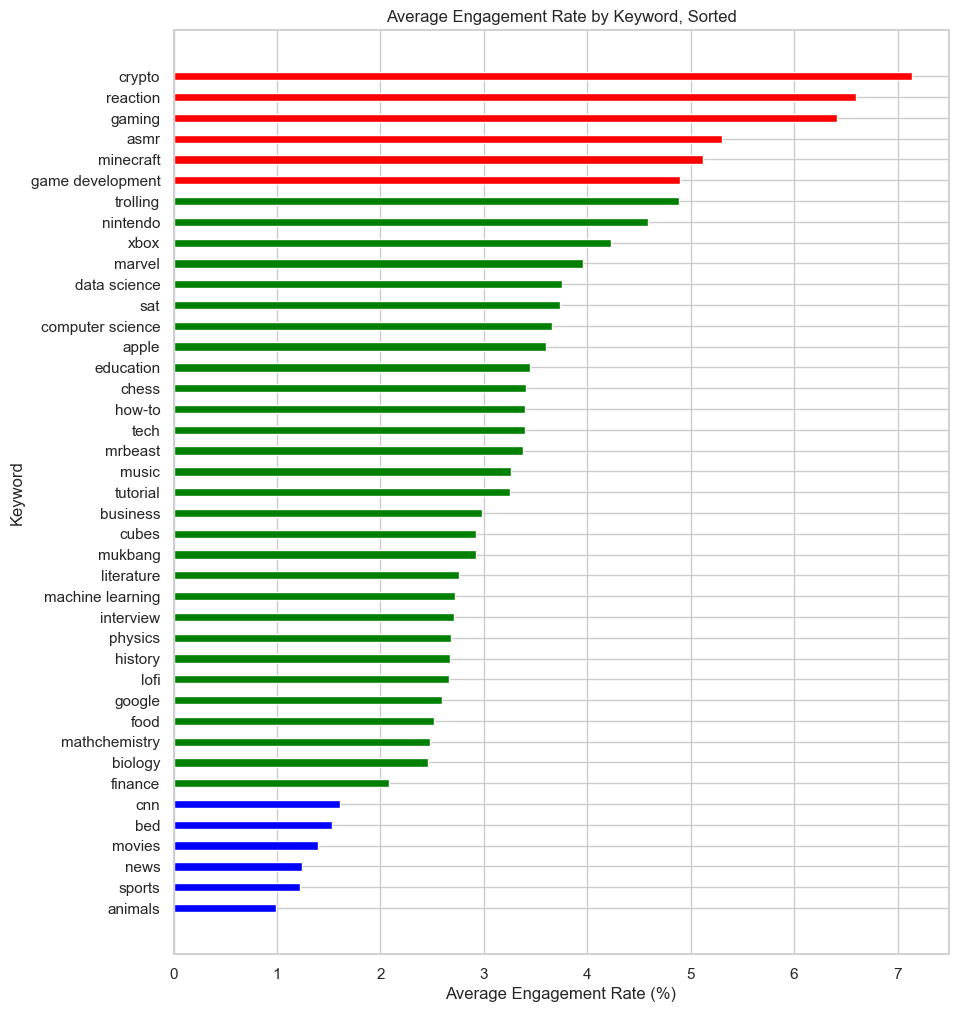

In [171]:
import matplotlib.pyplot as plt

# Determine the total number of bars
n_bars = len(keyword_engagement_sorted)

# Create a color list: blue for top 5, red for bottom 5, green for others
colors = ['blue' if i < 6 else 'red' if i >= n_bars - 6 else 'green' for i in range(n_bars)]

# Increase the figure height in the figsize attribute for better visualization
plt.figure(figsize=(10, 12))
plt.barh(keyword_engagement_sorted.index, keyword_engagement_sorted.values, color=colors, height=0.4)
plt.ylabel('Keyword')
plt.xlabel('Average Engagement Rate (%)')
plt.title('Average Engagement Rate by Keyword, Sorted')
plt.show()


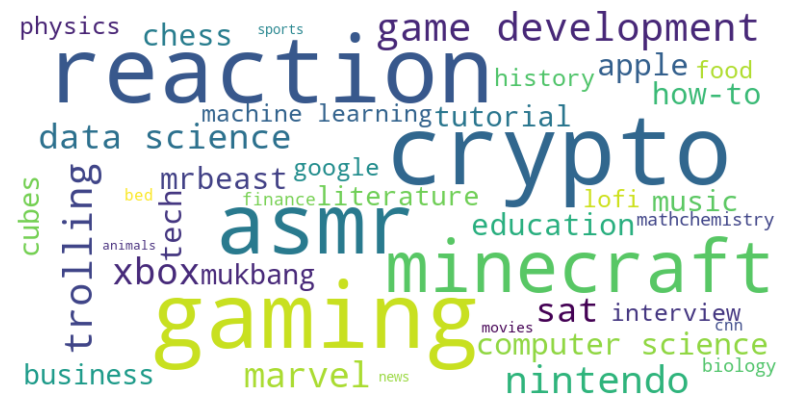

In [172]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Creating a dictionary from the sorted keywords and their values
keyword_frequencies = {keyword: value for keyword, value in zip(keyword_engagement_sorted.index, keyword_engagement_sorted.values)}

# Creating the word cloud with maximum font size adjusted for visibility
wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate_from_frequencies(keyword_frequencies)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis for this plot
plt.show()


In [173]:
unique_keywords = merged_df['Keyword'].unique()
unique_keywords

array(['tech', 'news', 'gaming', 'sports', 'how-to', 'business',
       'tutorial', 'finance', 'crypto', 'cubes', 'chess', 'apple',
       'google', 'interview', 'history', 'literature', 'bed', 'trolling',
       'asmr', 'music', 'food', 'mukbang', 'reaction', 'lofi', 'animals',
       'education', 'minecraft', 'sat', 'mrbeast', 'cnn', 'mathchemistry',
       'biology', 'physics', 'computer science', 'nintendo', 'xbox',
       'marvel', 'movies', 'data science', 'game development',
       'machine learning'], dtype=object)

## Keyword-based Classification

- Technology
- Education
- Media & Entertainment
- Food & Beverage
- Gaming
- Sports
- Arts & Entertainment
- Pets & Animals

In [174]:
industry_map = {
    "Technology": [
        "tech", "apple", "google", "computer science", "data science", "machine learning"
    ],
    "Business & Finance": [
        "business", "finance", "crypto", "interview", "news"
    ],
    "Gaming": [
        "gaming", "tutorial", "nintendo", "xbox", "minecraft", "game development"
    ],
    "Media & Entertainment": [
        "movies", "marvel", "mrbeast", "cnn", "mukbang", "reaction"
    ],
    "Sports": [
        "sports", "chess", "cubes"
    ],
    "Education": [
        "how-to", "history", "literature", "education", "math", "chemistry", "biology", "physics", "sat"
    ],
    "Lifestyle & Leisure": [
        "food", "bed", "animals", "trolling", "asmr", "music", "lofi"
    ]
}

In [175]:
industry_map_data = [(keyword, industry) for industry, keywords in industry_map.items() for keyword in keywords]

# Create the DataFrame
industry_map_df = pd.DataFrame(industry_map_data, columns=['Keyword', 'Industry'])
industry_map_df.head()

,Keyword,Industry
0,tech,Technology
1,apple,Technology
2,google,Technology
3,computer science,Technology
4,data science,Technology


In [176]:
merged_df = pd.merge(merged_df, industry_map_df, on='Keyword', how='left')
merged_df

,Video ID,Comment,Likes_x,Sentiment,Title,Published At,Keyword,Likes_y,Comments,Views,_merge,comments_count,Engagement Rate,Industry
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both,10,2.519689,Technology
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both,10,2.519689,Technology
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both,10,2.519689,Technology
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both,10,2.519689,Technology
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,both,10,2.519689,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17719,cyLWtMSry58,I really like the point about engineering tool...,0,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both,10,2.500672,Technology
17720,cyLWtMSry58,I’ve just started exploring this field. And th...,20,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both,10,2.500672,Technology
17721,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,1,1,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both,10,2.500672,Technology
17722,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,2,Don&#39;t learn machine learning,2020-03-30,machine learning,14787.0,814.0,591721.0,both,10,2.500672,Technology


In [177]:
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        # Handle potential errors (e.g., empty text)
        return False

In [178]:
merged_df = merged_df[merged_df['Comment'].apply(is_english)]

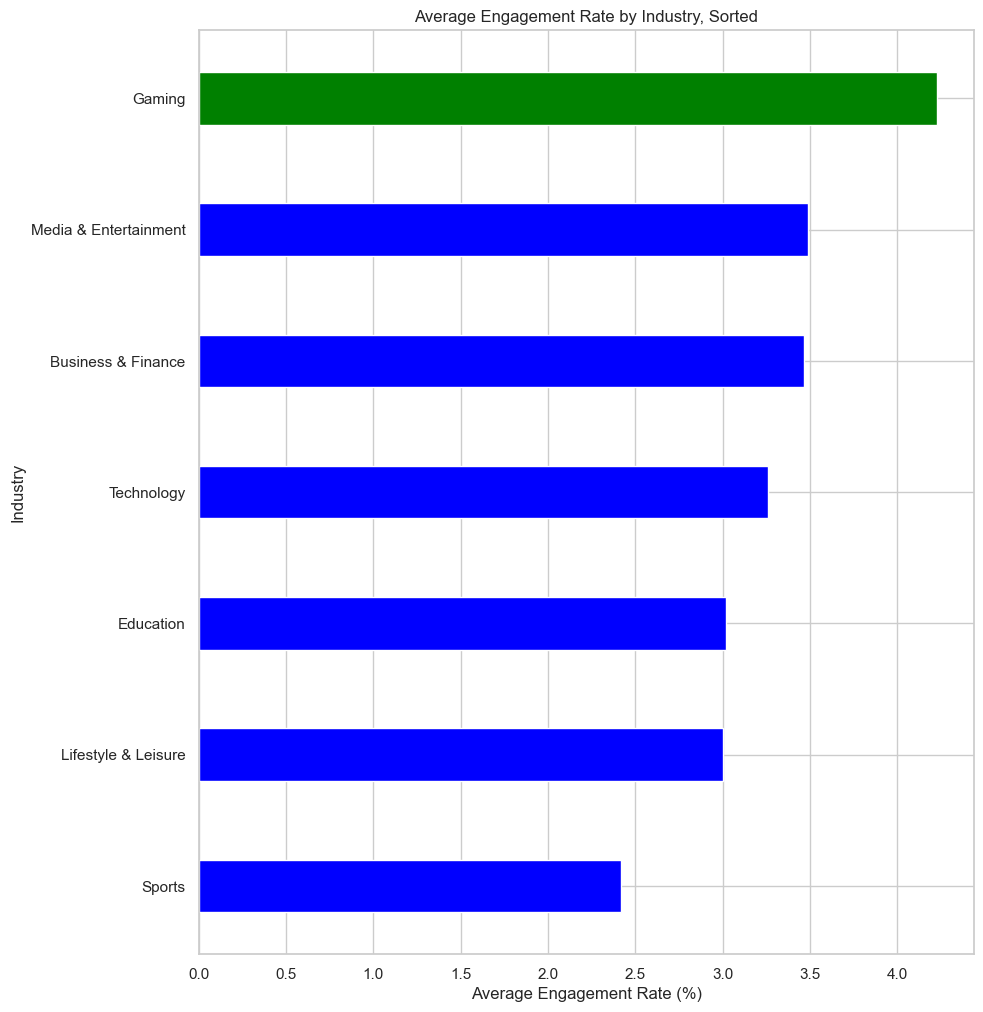

In [179]:
# Assuming you have a DataFrame where 'industry' is a column
# Replace 'industry_column_name' with the actual column name in your DataFrame
industry_engagement_sorted = merged_df.groupby('Industry')['Engagement Rate'].mean().sort_values(ascending=True)

# Determine the total number of bars
nn_bars = len(industry_engagement_sorted)

# Increase the figure height in the figsize attribute for better visualization
plt.figure(figsize=(10, 12))
plt.barh(industry_engagement_sorted.index, industry_engagement_sorted.values, color=colors, height=0.4)
plt.ylabel('Industry')
plt.xlabel('Average Engagement Rate (%)')
plt.title('Average Engagement Rate by Industry, Sorted')
plt.show()


In [180]:
# Assuming the DataFrame is named merged_df

# Group by 'Industry' and 'Keyword' and aggregate the metrics
keyword_popularity = merged_df.groupby(['Industry', 'Keyword']).agg({
    'Likes_x': 'sum',           # Total likes
    'Comments': 'sum',          # Total comments
    'Views': 'sum',             # Total views
    'Engagement Rate': 'mean'   # Mean engagement rate
})

# Sort the DataFrame by total likes in descending order
keyword_popularity = keyword_popularity.sort_values(by='Likes_x', ascending=False)

keyword_popularity


Likes_x    Comments         Views  \
Industry              Keyword                                               
Media & Entertainment mrbeast           2382827  18483943.0  1.668321e+10   
                      marvel             746369   4378702.0  2.937220e+09   
Education             how-to             710479   3253487.0  3.562333e+09   
                      biology            665959   2001957.0  1.908798e+09   
Gaming                tutorial           567568   3900680.0  3.124213e+09   
Technology            tech               497597   2830600.0  1.793906e+09   
Education             sat                495387    953958.0  5.007241e+08   
Lifestyle & Leisure   trolling           465395   1485642.0  6.878313e+08   
Sports                chess              458978    652324.0  5.766361e+08   
Business & Finance    interview          431464   2652290.0  1.438910e+09   
Lifestyle & Leisure   bed                398690   3978641.0  1.496309e+10   
                      lofi               377689    900146.0  1.502280e+09   
                      food               372106   2517256.0  2.379791e+09   
Education             physics            344470   2188853.0  1.817906e+09   
Sports                cubes              340701   2624122.0  6.029036e+09   
Education             history            334860   1700017.0  1.530952e+09   
Gaming                nintendo           325301   1720177.0  7.594332e+08   
Technology            google             315338   2550128.0  4.229220e+09   
                      computer science   307785    536697.0  5.559193e+08   
Lifestyle & Leisure   animals            307658   1585646.0  6.497578e+09   
Sports                sports             305496   1377536.0  2.988767e+09   
Media & Entertainment mukbang            214030   2206584.0  2.321880e+09   
Lifestyle & Leisure   asmr               189996    461311.0  4.973037e+08   
Gaming                game development   183516    668444.0  3.511925e+08   
Education             education          180053    947792.0  6.183748e+08   
                      literature         160071    396752.0  3.800382e+08   
Lifestyle & Leisure   music              142147   2098585.0  3.683213e+09   
Business & Finance    business           116260    698689.0  2.192538e+09   
Technology            machine learning   105024    594805.0  6.140040e+08   
Media & Entertainment movies             104681   1255764.0  9.410427e+08   
Technology            apple               99957    657456.0  2.516758e+08   
Gaming                xbox                98477   1348562.0  7.951114e+08   
Media & Entertainment cnn                 84770   3722769.0  2.721261e+08   
Business & Finance    finance             56801    405431.0  2.615098e+08   
Gaming                gaming              55618    399238.0  1.593314e+08   
Technology            data science        51061    217845.0  2.345163e+08   
Media & Entertainment reaction            47944    350511.0  5.728815e+07   
Gaming                minecraft           47886   1079354.0  7.638389e+08   
Business & Finance    crypto              23555    220492.0  1.341299e+08   
                      news                20272    371705.0  7.478016e+07   

                                        Engagement Rate  
Industry              Keyword                            
Media & Entertainment mrbeast                  3.345541  
                      marvel                   4.031483  
Education             how-to                   3.424513  
                      biology                  2.474775  
Gaming                tutorial                 3.325560  
Technology            tech                     3.370613  
Education             sat                      3.797606  
Lifestyle & Leisure   trolling                 4.966147  
Sports                chess                    3.136579  
Business & Finance    interview                2.691125  
Lifestyle & Leisure   bed                      1.593735  
                      lofi                     2.21

In [181]:
# Create the DataFrame
keyword_popularity_df = pd.DataFrame(keyword_popularity, columns=[])

keyword_popularity_df

Empty DataFrame
Columns: []
Index: [(Media & Entertainment, mrbeast), (Media & Entertainment, marvel), (Education, how-to), (Education, biology), (Gaming, tutorial), (Technology, tech), (Education, sat), (Lifestyle & Leisure, trolling), (Sports, chess), (Business & Finance, interview), (Lifestyle & Leisure, bed), (Lifestyle & Leisure, lofi), (Lifestyle & Leisure, food), (Education, physics), (Sports, cubes), (Education, history), (Gaming, nintendo), (Technology, google), (Technology, computer science), (Lifestyle & Leisure, animals), (Sports, sports), (Media & Entertainment, mukbang), (Lifestyle & Leisure, asmr), (Gaming, game development), (Education, education), (Education, literature), (Lifestyle & Leisure, music), (Business & Finance, business), (Technology, machine learning), (Media & Entertainment, movies), (Technology, apple), (Gaming, xbox), (Media & Entertainment, cnn), (Business & Finance, finance), (Gaming, gaming), (Technology, data science), (Media & Entertainment, reaction), (Gaming, minecraft), (Business & Finance, crypto), (Business & Finance, news)]

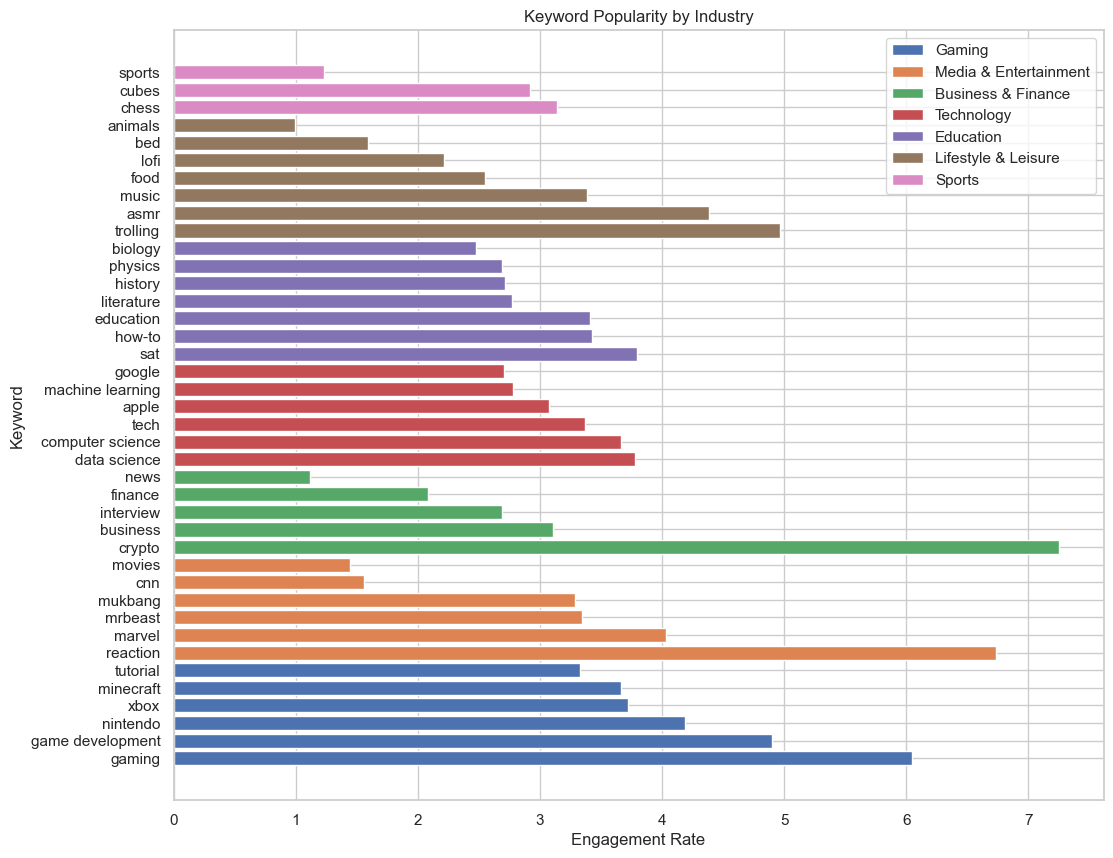

In [182]:
# Calculate the sum of engagement rates for each industry and sort the industries by this sum
industry_engagement= keyword_popularity.groupby('Industry')['Engagement Rate'].mean().sort_values(ascending=False)

# Plot settings
plt.figure(figsize=(12, 10))
plt.title('Keyword Popularity by Industry')
plt.xlabel('Engagement Rate')
plt.ylabel('Keyword')

# Iterate over each industry sorted by overall popularity and plot a horizontal bar chart for keyword popularity
for industry in industry_engagement.index:
    data = keyword_popularity.loc[industry].sort_values(by='Engagement Rate', ascending=False)
    plt.barh(data.index.get_level_values('Keyword'), data['Engagement Rate'], label=industry)

# Add legend
plt.legend()

# Show plot
plt.show()


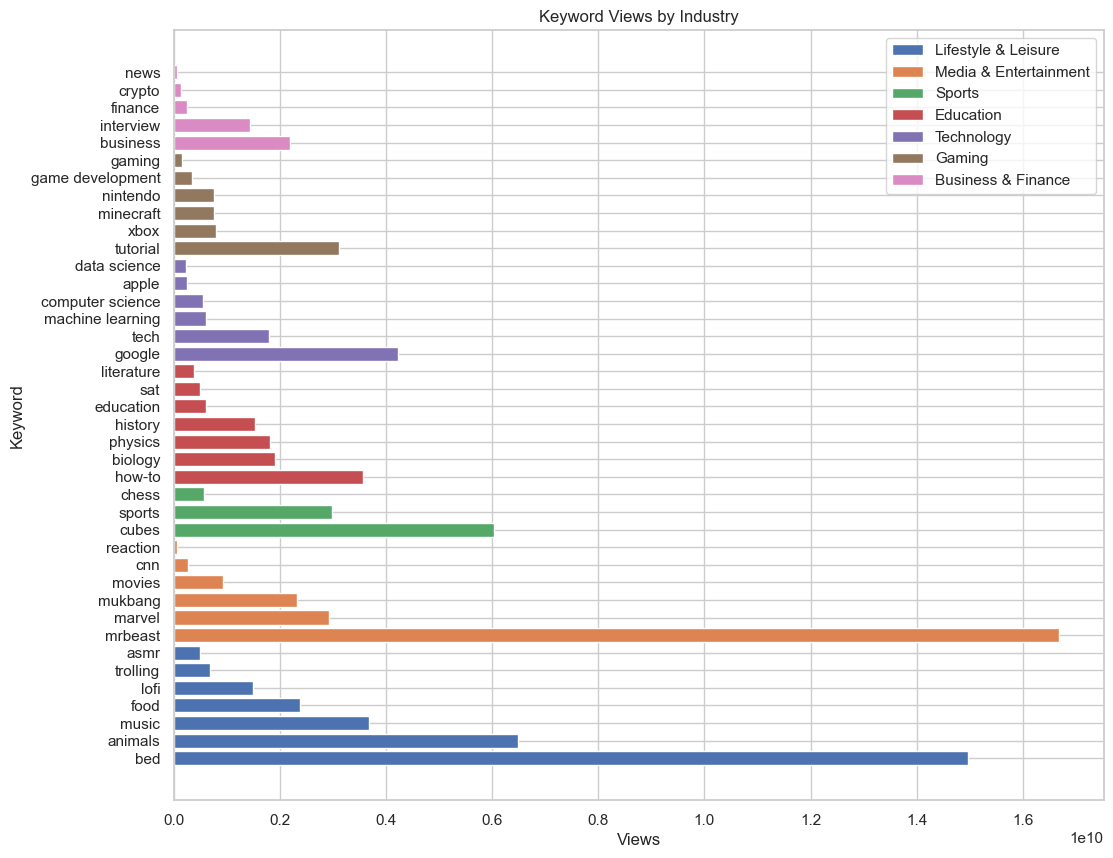

In [183]:
# Calculate the sum of engagement rates for each industry and sort the industries by this sum
industry_view = keyword_popularity.groupby('Industry')['Views'].mean().sort_values(ascending=False)

# Plot settings
plt.figure(figsize=(12, 10))
plt.title('Keyword Views by Industry')
plt.xlabel('Views')
plt.ylabel('Keyword')

# Iterate over each industry sorted by overall popularity and plot a horizontal bar chart for keyword popularity
for industry in industry_view.index:
    data = keyword_popularity.loc[industry].sort_values(by='Views', ascending=False)
    plt.barh(data.index.get_level_values('Keyword'), data['Views'], label=industry)

# Add legend
plt.legend()

# Show plot
plt.show()


# 2. Sentiment Analysis of Video Comments

Dataset provides the sentiment scale from 0 to 2. Since Sentiment is only identifying the negativity and positive, it is not as detail as to identify the emotion & opinions.So we will further investigate the sentiment of the comments after identifying the propotion of positive and negative comments.


##2.1 Emotional landscape

## 2.2 First Element - Opinion


**Sentiment EDA**

In [184]:
merged_df.Sentiment.value_counts()

Sentiment
2    10281
1     3243
0     2249
Name: count, dtype: int64

In [185]:
temp = merged_df.groupby('Sentiment').count()['Comments'].reset_index().sort_values(by='Comments',ascending=False)
temp.style.background_gradient(cmap='Greens')

,Sentiment,Comments
2,2,10281
1,1,3243
0,0,2249


In [186]:
# Group by 'Sentiment' and count the 'Comments', then reset the index and sort
temp = merged_df.groupby('Sentiment').count()['Comments'].reset_index().sort_values(by='Comments', ascending=False)

# Add a new column with sentiment words
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
temp['Sentiment_Words'] = temp['Sentiment'].map(sentiment_mapping)
temp

,Sentiment,Comments,Sentiment_Words
2,2,10281,Positive
1,1,3243,Neutral
0,0,2249,Negative


This is one of the first element that goes into a sentiment analysis system which is **Opinion**

Opinion has three divisions: positive, neutral, and negative.

In this case
- Positive = 2
- neutral = 1
- nagative = 0


In [187]:
sentiment_percentage = merged_df.Sentiment.value_counts()/len(merged_df)
sentiment_percentage

Sentiment
2    0.651810
1    0.205605
0    0.142585
Name: count, dtype: float64

<Axes: xlabel='Sentiment', ylabel='count'>

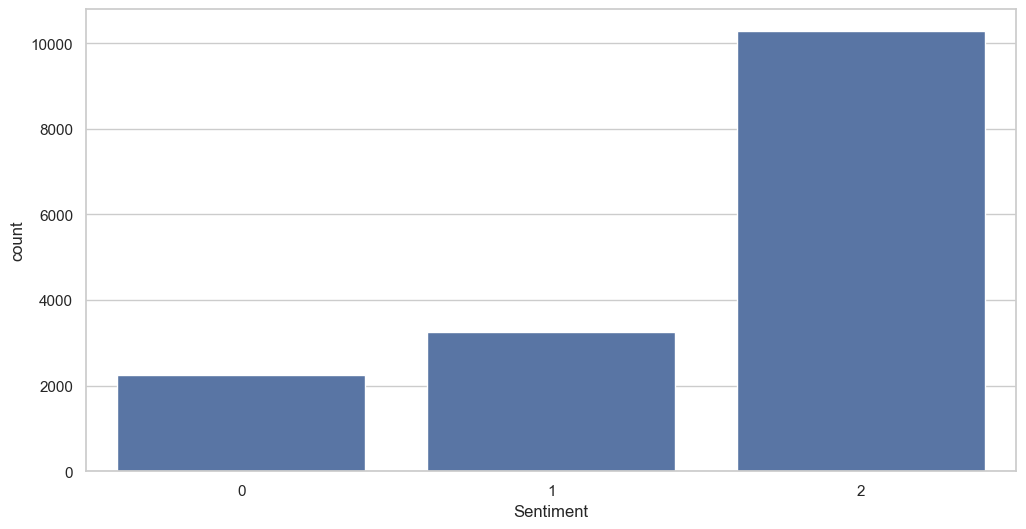

In [188]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=merged_df)

Overall Positive comments are most common among videos.


Positive comments are 62% <br />
Neutral comments are 25.1%
Negative comments are 12.9$  <br />

Let's find out which types



In [189]:
# Group by 'Industry' and 'Keyword' and aggregate the metrics
keyword_sentiment = merged_df.groupby(['Industry', 'Keyword']).agg({
    'Sentiment': 'mean'  # Calculate mean sentiment
})

# Sort the DataFrame by 'Sentiment' in descending order
keyword_sentiment = keyword_sentiment.sort_values(by=['Industry', 'Sentiment'], ascending=[False, False])

# Display the sorted DataFrame
keyword_sentiment.head()

Sentiment
Industry   Keyword                    
Technology machine learning   1.756098
           data science       1.713062
           computer science   1.612108
           tech               1.505232
           apple              1.424501

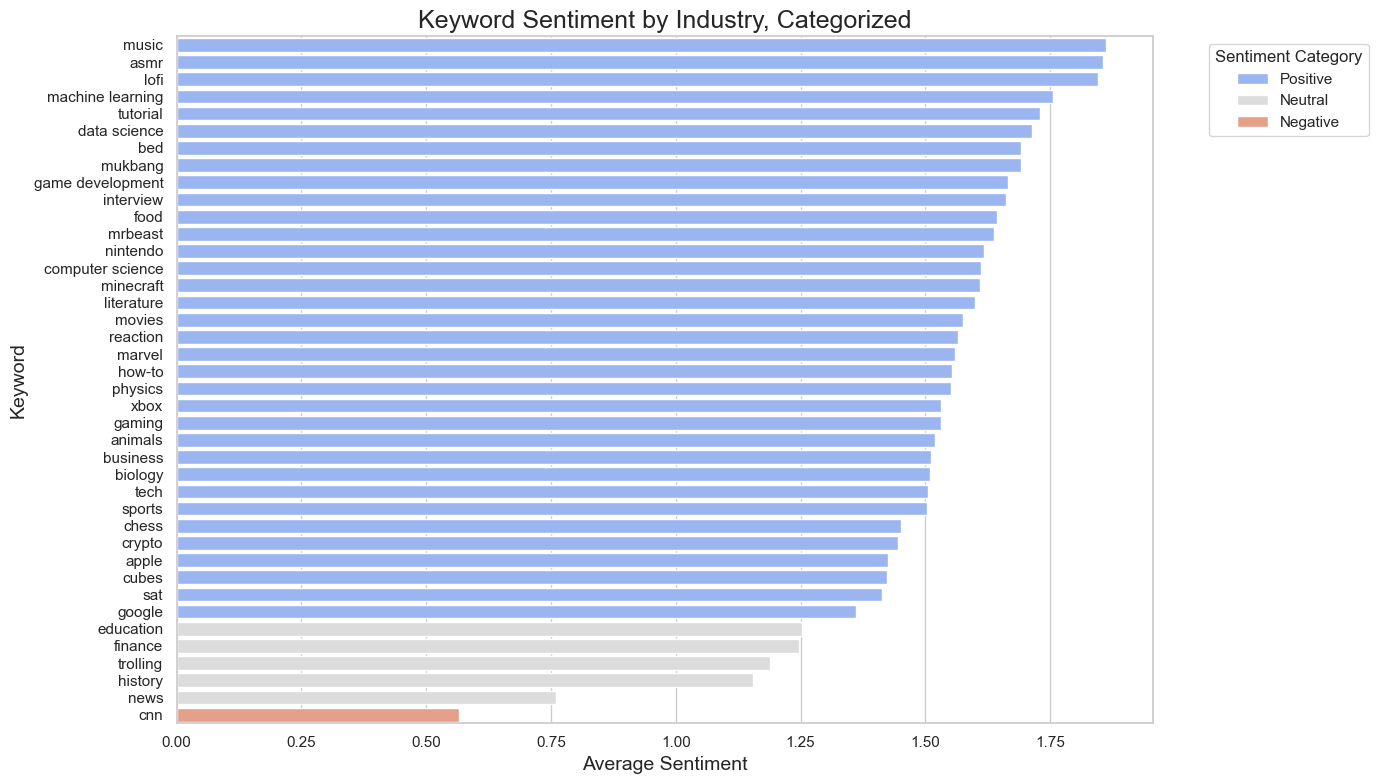

In [190]:
# Group by 'Industry' and 'Keyword' and calculate the mean sentiment
keyword_sentiment = merged_df.groupby(['Industry', 'Keyword']).agg({
    'Sentiment': 'mean'  # Calculate mean sentiment
}).reset_index()

# Categorize sentiments
def categorize_sentiment(sentiment):
    if 0 <= sentiment < 0.666:
        return 'Negative'
    elif 0.666 <= sentiment < 1.332:
        return 'Neutral'
    elif 1.332 <= sentiment <= 2:
        return 'Positive'

keyword_sentiment['Sentiment Category'] = keyword_sentiment['Sentiment'].apply(categorize_sentiment)


#Sort value
keyword_sentiment = keyword_sentiment.sort_values(by='Sentiment', ascending=False)


# Set plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(data=keyword_sentiment, x='Sentiment', y='Keyword', hue='Sentiment Category', palette='coolwarm')

# Improve the layout
plt.title('Keyword Sentiment by Industry, Categorized', fontsize=18)
plt.xlabel('Average Sentiment', fontsize=14)
plt.ylabel('Keyword', fontsize=14)
plt.legend(title='Sentiment Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plot
plt.show()

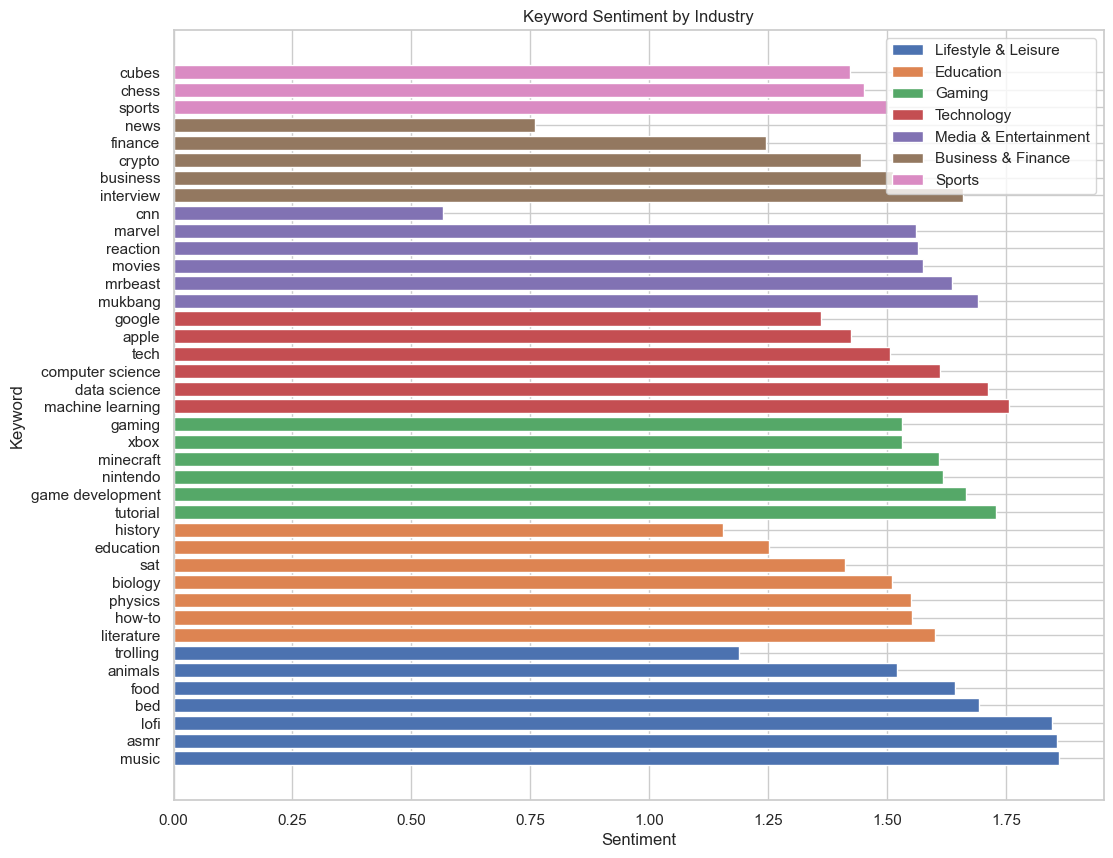

In [191]:
industry_sentiment_sum = keyword_sentiment.groupby('Industry')['Sentiment'].sum().sort_values(ascending=False)

# Plot settings
plt.figure(figsize=(12, 10))
plt.title('Keyword Sentiment by Industry')
plt.xlabel('Sentiment')
plt.ylabel('Keyword')

# Iterate over each industry sorted by overall popularity and plot a horizontal bar chart for keyword popularity
for industry in industry_sentiment_sum.index:
    # Filter data for the current industry
    data_sentiment = keyword_sentiment[keyword_sentiment['Industry'] == industry].sort_values(by='Sentiment', ascending=False)

    # Plot horizontal bar chart
    plt.barh(data_sentiment['Keyword'], data_sentiment['Sentiment'], label=industry)

# Add legend
plt.legend()
# Show plot
plt.show()

## First Element: Emotion
The categorical model of emotion analysis places a person's emotions into six basic categories, like anger, fear, disgust, joy, sadness, and surprise. Specific words are linked to relevant emotion tags and used to detect both related and unrelated emotions([Reference](https://www.delve.ai/blog/emotion-analysis#:~:text=The%20categorical%20model%20of%20emotion,both%20related%20and%20unrelated%20emotions.)).


https://pypi.org/project/NRCLex/



In [192]:
# Function to calculate emotion scores
def get_emotion_scores(comment):
    emotions = NRCLex(comment).affect_frequencies
    return emotions

# Create a new DataFrame to work with
comment_df = merged_df.copy()

# Apply function to the comments column
comment_df.loc[:, 'Emotion Scores'] = comment_df['Comment'].apply(get_emotion_scores)

# Extract specific emotions and add them to the DataFrame
emotion_columns = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'disgust', 'joy']

for emotion in emotion_columns:
    comment_df.loc[:, emotion] = comment_df['Emotion Scores'].apply(lambda x: x.get(emotion.lower(), 0))

# Drop intermediate column
comment_df = comment_df.drop(columns=['Emotion Scores'])

# Display the DataFrame
comment_df.head()


,Video ID,Comment,Likes_x,Sentiment,Title,Published At,Keyword,Likes_y,Comments,Views,...,Engagement Rate,Industry,fear,anger,anticipation,trust,surprise,sadness,disgust,joy
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.125000,0.375000,0.000000,0.000000,0.000000,0.250000
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.090909,0.136364,0.136364,0.090909,0.090909,0.090909,0.045455,0.045455
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,3407.0,672.0,135612.0,...,2.519689,Technology,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000


In [193]:
# Save the DataFrame as a CSV file
comment_df.to_csv('comment_df.csv', index=False)

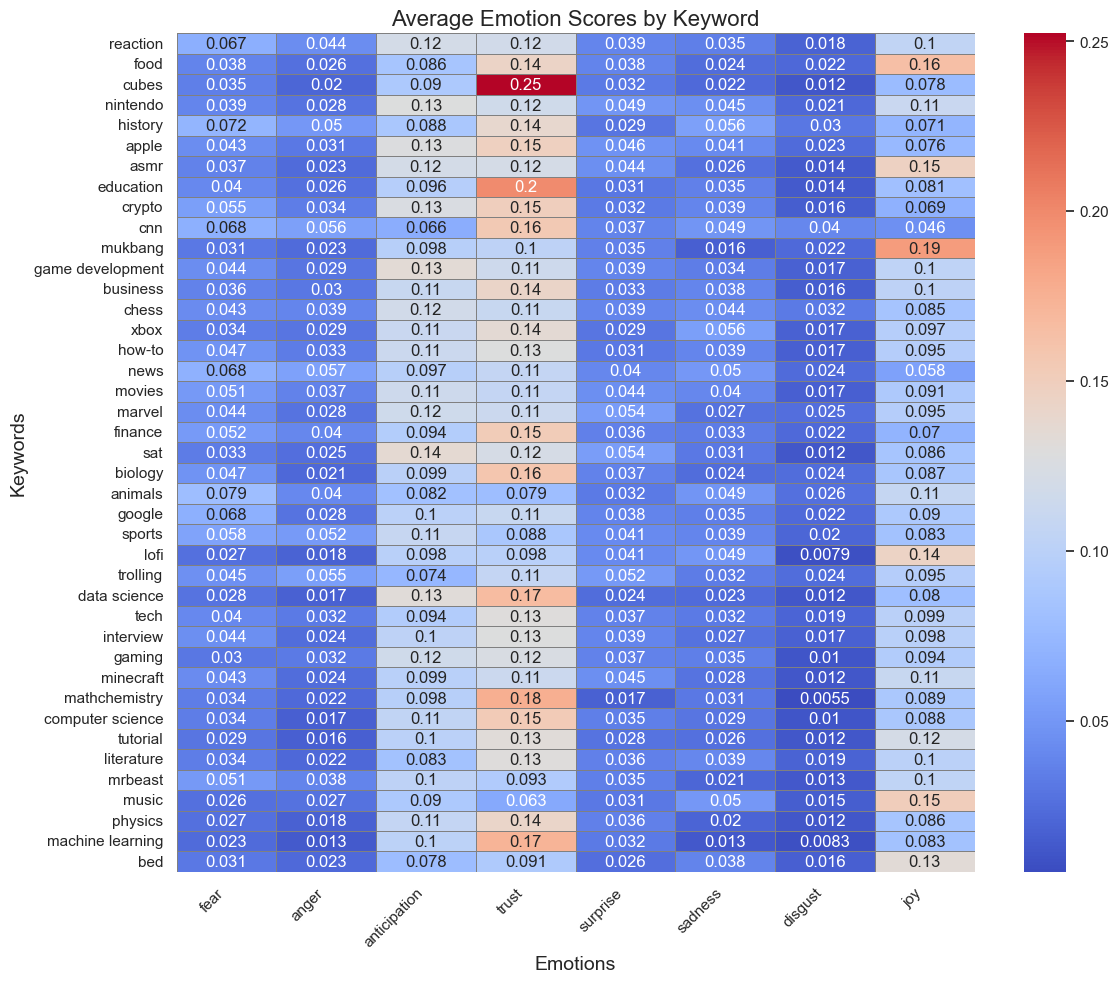

In [194]:
# Assuming there's a 'Keyword' column in your DataFrame
# Aggregate the scores by keyword (assuming you have a 'Keyword' column)
keyword_avg_df = comment_df.groupby('Keyword')[emotion_columns].mean()

# Calculate the sum of emotion scores for each keyword
keyword_avg_df['Total'] = keyword_avg_df.sum(axis=1)

# Sort the DataFrame based on the total emotion scores
keyword_avg_df = keyword_avg_df.sort_values(by='Total', ascending=False).drop(columns='Total').reset_index()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(keyword_avg_df.set_index('Keyword'), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Average Emotion Scores by Keyword", fontsize=16)
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Keywords", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

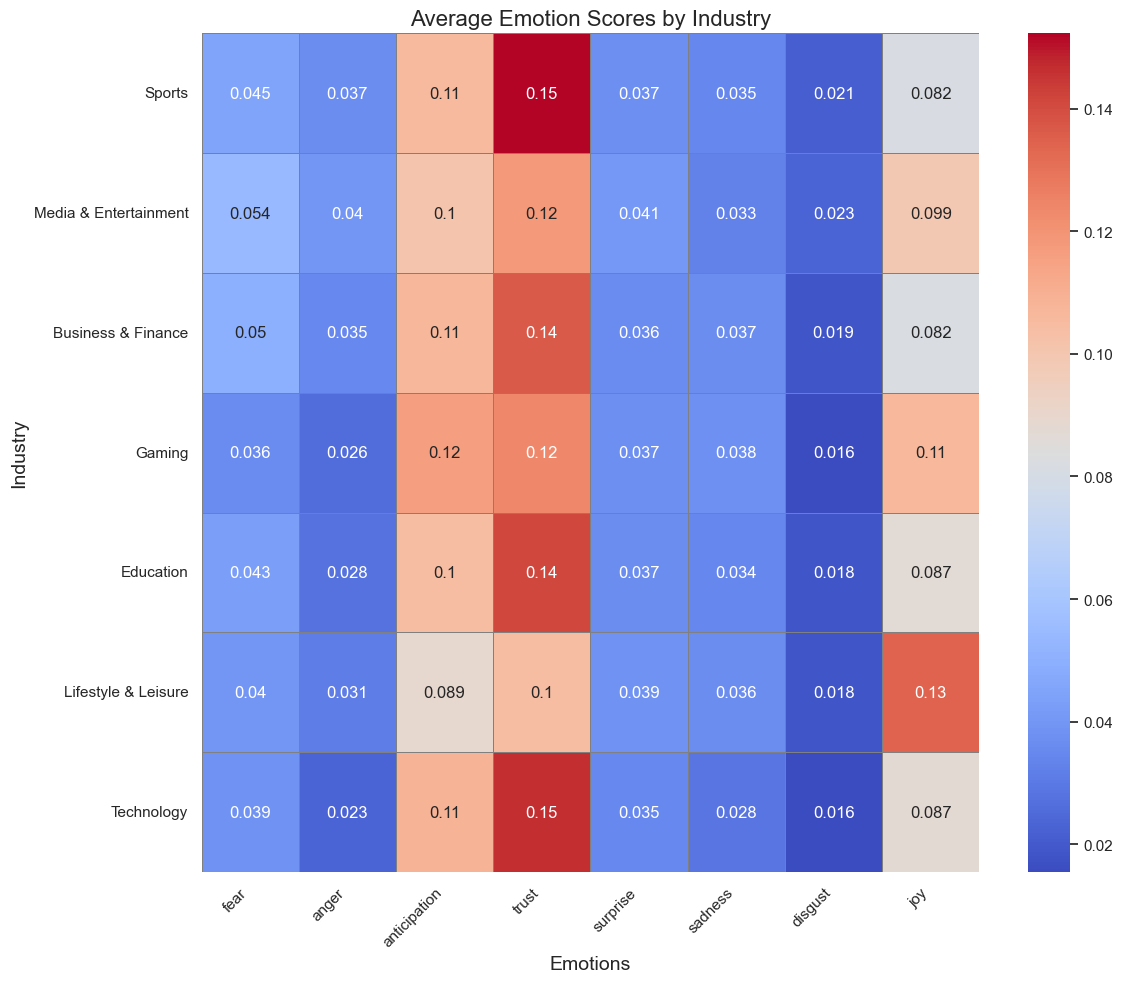

In [195]:
# Assuming there's a 'Keyword' column in your DataFrame
# Aggregate the scores by keyword (assuming you have a 'Keyword' column)
industry_avg_df = comment_df.groupby('Industry')[emotion_columns].mean()

# Calculate the sum of emotion scores for each keyword
industry_avg_df['Total'] = industry_avg_df.sum(axis=1)

# Sort the DataFrame based on the total emotion scores
industry_avg_df = industry_avg_df.sort_values(by='Total', ascending=False).drop(columns='Total').reset_index()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(industry_avg_df.set_index('Industry'), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Average Emotion Scores by Industry", fontsize=16)
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Industry", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

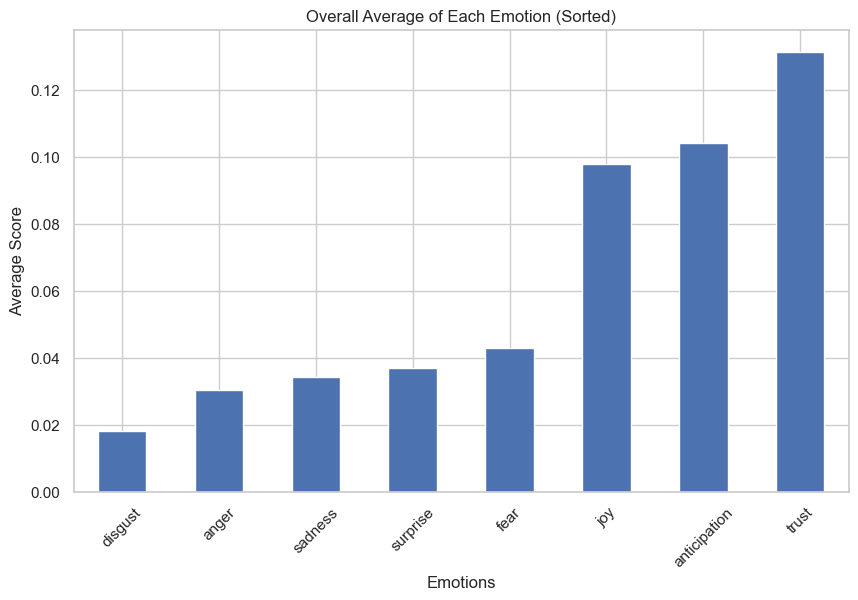

In [196]:

# Calculate the overall average of each emotion
average_emotions = comment_df[emotion_columns].mean().sort_values()

# Plot the bar graph
plt.figure(figsize=(10, 6))
average_emotions.plot(kind='bar')
plt.title('Overall Average of Each Emotion (Sorted)')
plt.xlabel('Emotions')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

## 2.1 Identifying trends

### Time Series

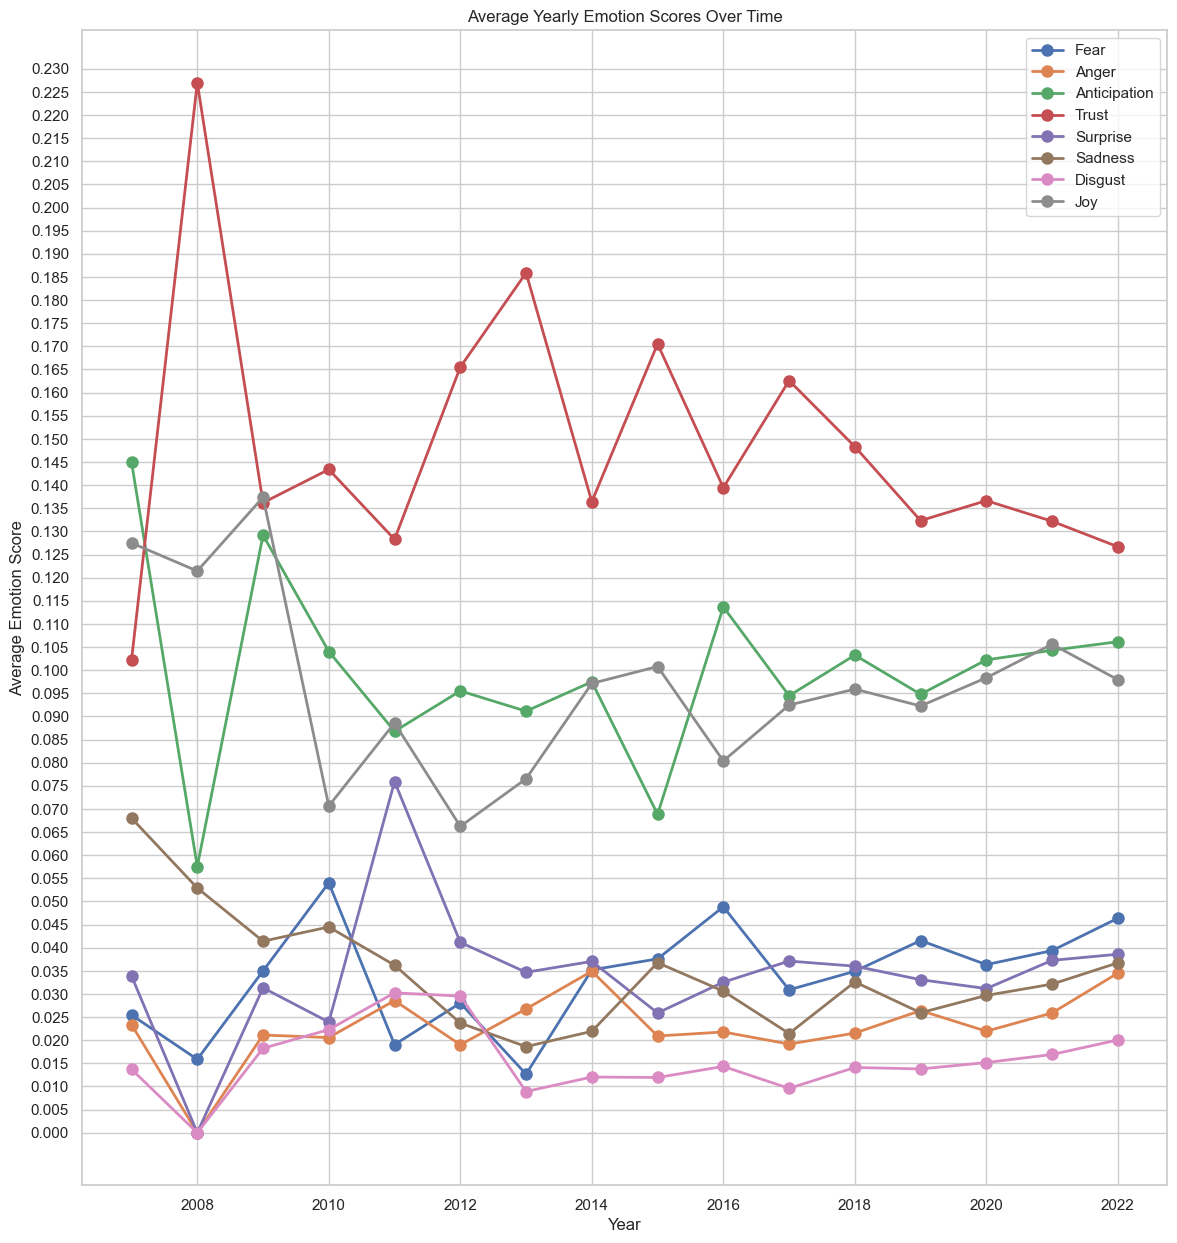

In [197]:
# Resample data by year and calculate average emotion scores
resampled_data = comment_df.resample('Y', on='Published At')[emotion_columns].mean()

# Create time series plot
plt.figure(figsize=(14, 15))

for emotion in emotion_columns:
    plt.plot(resampled_data.index.year, resampled_data[emotion], marker='o', markersize=8, linestyle='-', linewidth=2, label=emotion.capitalize())

plt.xlabel('Year')
plt.ylabel('Average Emotion Score')
plt.title('Average Yearly Emotion Scores Over Time')
plt.legend()

# Set custom y-axis ticks with increments of 0.005
plt.yticks(np.arange(resampled_data.min().min(), resampled_data.max().max() + 0.005, 0.005))

plt.grid(True)
plt.show()

#### General observation

- Trust is the most dominant emotion throughout the years, consistently having the highest average scores compared to other emotions.
- Anticipation and Joy also show relatively high scores, with Anticipation peaking several times.
- Surprise, Sadness, Fear, Anger, and Disgust have lower average scores compared to Trust, Anticipation, and Joy.


#### Specific Trends

In [198]:
# Resample data by year and calculate average emotion scores
resampled_data = comment_df.resample('Y', on='Published At')[emotion_columns].mean()

# Calculate peaks and trends for each emotion
trends = {}

for emotion in emotion_columns:
    emotion_data = resampled_data[emotion]
    peaks = emotion_data[(emotion_data.shift(1) < emotion_data) & (emotion_data.shift(-1) < emotion_data)]
    trends[emotion] = {
        'peaks': peaks,
        'max': emotion_data.max(),
        'min': emotion_data.min(),
        'trend': 'decreasing' if emotion_data.iloc[-1] < emotion_data.iloc[0] else 'increasing'
    }

# Display the trends
for emotion, data in trends.items():
    print(f"{emotion.capitalize()}:")
    print(f"  Peaks: {data['peaks'].index.year.tolist()} at values {data['peaks'].values}")
    print(f"  Max: {data['max']}")
    print(f"  Min: {data['min']}")
    print(f"  Overall trend: {data['trend']}")

# For further analysis, let's extract the specific information
trust_peaks = trends['trust']['peaks'].index.year.tolist()
anticipation_peaks = trends['anticipation']['peaks'].index.year.tolist()
joy_peaks = trends['joy']['peaks'].index.year.tolist()
fear_peaks = trends['fear']['peaks'].index.year.tolist()
sadness_peaks = trends['sadness']['peaks'].index.year.tolist()

# Additional analysis for individual peaks in Fear and Sadness
print(f"Trust peaks: {trust_peaks}")
print(f"Anticipation peaks: {anticipation_peaks}")
print(f"Joy peaks: {joy_peaks}")
print(f"Fear peaks: {fear_peaks}")
print(f"Fear peaks: {sadness_peaks}")


# Optionally, you can store these trends in a DataFrame for better visualization
trends_df = pd.DataFrame(trends).T
print(trends_df)

Fear:
  Peaks: [2010, 2012, 2016, 2019] at values [0.0540352  0.02804082 0.04885143 0.04154807]
  Max: 0.054035197985760335
  Min: 0.012666135034556087
  Overall trend: increasing
Anger:
  Peaks: [2009, 2011, 2014, 2016, 2019] at values [0.02112485 0.02857267 0.03491604 0.02178122 0.02640936]
  Max: 0.034916037298581226
  Min: 0.0
  Overall trend: increasing
Anticipation:
  Peaks: [2009, 2012, 2014, 2016, 2018] at values [0.12918904 0.09551243 0.09748067 0.11367295 0.10325379]
  Max: 0.14499367952309128
  Min: 0.05753968253968253
  Overall trend: decreasing
Trust:
  Peaks: [2008, 2010, 2013, 2015, 2017, 2020] at values [0.22698413 0.14338529 0.18588029 0.170524   0.16259999 0.13665172]
  Max: 0.22698412698412695
  Min: 0.10219370825253178
  Overall trend: increasing
Surprise:
  Peaks: [2009, 2011, 2014, 2017] at values [0.03132879 0.07591662 0.03704152 0.03711222]
  Max: 0.0759166230594802
  Min: 0.0
  Overall trend: increasing
Sadness:
  Peaks: [2010, 2015, 2018] at values [0.04448617

Specific Trends:
- Trust:
    - Peaks around 2007 and 2013.
    - Shows a general decline from 2014 to 2022.
- Anticipation:
    - Highly variable with notable peaks in 2007, 2011, and 2014.
    - Slightly more stable but still fluctuating in the later years.
- Joy:
    - Peaks around 2007 and 2011, followed by smaller peaks in subsequent years.
    - Somewhat stable with moderate fluctuations.
- Sadness, Fear, Anger, and Disgust:
    - All four emotions show lower and more consistent scores over time.
    - Notable peaks for Fear and Sadness around 2010 and 2011.
    - Disgust and Anger have occasional minor peaks but remain relatively low.

#### Yearly Patterns

- Early Years (2006-2010):
    - High variability in emotions, with multiple peaks, especially for Trust, Anticipation, and Fear.
- Middle Years (2011-2015):
    - Trust and Anticipation show notable peaks.
    - Joy remains relatively high but stable.
    - Lower emotions maintain consistency.
- Recent Years (2016-2022):
    - A slight downward trend in Trust.
    - Anticipation and Joy show less variability.
    - Fear, Sadness, Anger, and Disgust remain consistently low.

# 3. Development of a Video Ranking Model


In [199]:
from sklearn.model_selection import train_test_split

In [200]:
rankingdata =pd.DataFrame(comment_df)

In [201]:
# Features and target variable
features = ['Views', 'Likes_y', 'Comments', 'Sentiment', 'fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'disgust', 'joy']
target = 'Engagement Rate'

# Split the data into training and testing sets
train_df, test_df = train_test_split(rankingdata, test_size=0.3, random_state=42)

# Separate features and target
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (11041, 12)
Testing Data Shape: (4732, 12)


In [202]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define a dictionary to store models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Define evaluation metrics
evaluation_metrics = {
    "Mean Absolute Error": mean_absolute_error,
    "Mean Squared Error": mean_squared_error
}

# Iterate over models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    print(f"Evaluating {name}:")
    for metric_name, metric_func in evaluation_metrics.items():
        metric_value = metric_func(y_test, predictions)
        print(f"{metric_name}: {metric_value:.4f}")
    print("="*30)

Training Linear Regression...
Evaluating Linear Regression:
Mean Absolute Error: 1.6399
Mean Squared Error: 4.9818
Training Decision Tree...
Evaluating Decision Tree:
Mean Absolute Error: 0.0015
Mean Squared Error: 0.0008
Training Random Forest...
Evaluating Random Forest:
Mean Absolute Error: 0.0093
Mean Squared Error: 0.0024
Training Gradient Boosting...
Evaluating Gradient Boosting:
Mean Absolute Error: 0.3556
Mean Squared Error: 0.2852


In [203]:
# Make predictions on the testing data
predictions = model.predict(X_test)

# Evaluate the model using the chosen evaluation metric
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.28519985173058476


In [204]:
train_df, test_df = train_test_split(merged_df, test_size=0.3, random_state=42)

# Print the shapes of the resulting datasets
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Training Data Shape: (11041, 14)
Testing Data Shape: (4732, 14)


# 4. Strategic Recommendation for E-Learning Collaboration

In [205]:
data_ai_keywords = ["machine learning", "data science", "computer science"]

filtered_df = comment_df[comment_df['Keyword'].isin(data_ai_keywords)]

# Step 2: Calculate Engagement Score
def sentiment_score(sentiment):
  if sentiment == "positive":
    return 1
  elif sentiment == "negative":
    return -1
  else:
    return 0

filtered_df["sentiment_score"] = filtered_df["Sentiment"].apply(sentiment_score)
filtered_df["engagement_score"] = (filtered_df["sentiment_score"] + filtered_df["comments_count"]) / 2

# Step 3: Target Learner Filtering
beginner_keywords = ["introduction", "tutorial", "basics"]
advanced_keywords = ["advanced", "deep learning", "research"]

weight = 0.8

# Combine engagement score with target audience relevance score (set to 1 for now, adjust based on filtering)
filtered_df["final_score"] = (weight * filtered_df["engagement_score"]) + (1 - weight)

# Sort videos by final score in descending order
top_videos = filtered_df.sort_values(by="final_score", ascending=False).head(3)

# Get a list of dictionaries containing Video ID and Title
top_videos_list = top_videos[["Video ID", "Title"]].to_dict('records')

# Print results with Video ID and Title
print("Top 3 videos for promotion:")
for video in top_videos_list:
  print(f"\t- Video ID: {video['Video ID']}, Title: {video['Title']}")

# Top 3 video IDs for promotion
top_video_ids = top_videos["Video ID"].to_list()

# Print the Video IDs of the top 3 videos
print("Top 3 video IDs for promotion:", top_video_ids)

Top 3 videos for promotion:
	- Video ID: Tzl0ELY_TiM, Title: What is Computer Science?
	- Video ID: innk6tpRCW0, Title: Statistics for Data Science Full Course | Probability and Statistics for Engineers | Great Learning
	- Video ID: k2P_pHQDlp0, Title: AI VS ML VS DL VS Data Science
Top 3 video IDs for promotion: ['Tzl0ELY_TiM', 'innk6tpRCW0', 'k2P_pHQDlp0']


## 💪 Competition challenge

Create a report that covers the following:

1. **Exploratory Data Analysis of YouTube Trends:**
   - Conduct an initial analysis of YouTube video trends across different industries. This analysis should explore basic engagement metrics such as views, likes, and comments and identify which types of content are most popular in each industry.

2. **Sentiment Analysis of Video Comments:**
   - Perform a sentiment analysis on video comments to measure viewer perceptions. This task involves basic processing of text data and visualizing sentiment trends across various video categories.

3. **Development of a Video Ranking Model:**
   - Create a simple model that uses sentiment analysis results and traditional engagement metrics to rank videos. This model should help identify potentially valuable videos for specific industry sectors.

4. **Strategic Recommendation for E-Learning Collaboration:**
   - Use your model’s findings to identify YouTube videos that would be particularly effective for an **E-Learning platform focused on Data and AI skills**. Include recommendations for **three specific videos**, briefly explaining why each is ideal for promoting your E-Learning platform.

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights.
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error

## ⌛️ Time is ticking. Good luck!